# Train a model

__Before starting with "Train a model":__ you should read the notebook Create_train_dataset.ipynb and create a dataset

- 1- Create a data generator
- 2- Create a model/architecture
- 3- Train the model

## 1- Create a data generator

- __Create a data augmentation generator__ using Augmentor (module from pip) and Augmentor_add_on (Thibault addon in /unet_4_user/Augmentor_add_on.py)


- __Import the data.__ Data should be patches of size 256x256 or 512x512 in pair (image, mask)
    - Data are contained 2 sets: Data_train and Data_validation
    - Follow the guide from the notebook Create_training_dataset.ipynb to create a dataset with the appropriate structure. Example on dataset (and its structure for references) is located in /DataSet_demo/Patch_for_Training


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time

import json
from keras.models import model_from_json
from keras import optimizers

import datetime

import Augmentor

from tkinter import filedialog
from tkinter import Tk

In [27]:
##TORESOLVE : why in the file Training_tools I have to make the import "import utility.losses as losses"
# and not "import losses" wierd behaviour when run "Training_tools" from spyder error:
# "ModuleNotFoundError: No module named 'utility'"
from utility.Utility import Import_image
from utility.Utility_Dataset import get_data
from utility.Apply_model import Import_model, Unet_by_patches
import utility.Augmentor_add_on as aug_addon
from utility.Training_tools import train_UnAxSeg, UnAxSeg, UnAxSeg_2, losses, Generator_Augmented_Data

### 1.1 Create generator function

This function is used to generate a data augmentation generator.
it is not necessary to change the parameters of the different transformation as they correspond to range of value randomly picked during the data augmentation generation.
The parameter probability define the probability that the transformation takes place.

Recommended range for :
        - rotate : max 15, min 0
        - distortion : ???
        - shear : 15
        


In [3]:
# Create a generator
def Generator_Augmented_Data(Data_train, batch_size=10):
    
    p = Augmentor.DataPipeline(Data_train)
    
    p.rotate(probability=0.9, max_left_rotation=15, max_right_rotation=15)
    p.rotate90(probability=0.8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.random_distortion(probability=1,grid_width=1, grid_height=1, magnitude=8)
    p.shear(0.9,max_shear_left=10, max_shear_right=10)
    
    mask_3ch = aug_addon.Mask_3ch() # convert the masks in 3 channels with 0 or 1 value (hotshot)
    p.add_operation(mask_3ch)
    
    g =   p.keras_generator_with_mask(batch_size=batch_size)
    return g

### 1.2 Create generator for training data

- 1- Select the path where the training set image/mask are located
- 2- Create the iterator (generator) using the training set
- 3- Sanity check (size, shape and plot)
- 4- Repeat 1 and 2 for validation set

In [4]:
# option 1 Choose the location of the dataset manually
train_path = 'Data/dataset_demo/Patch_for_Training/train'
# option 1 for Mascha
# from the serve 50T take the folder  Axon/DeepSeg/UnAxSeg/Data  it contains all you need for the training
# Data/dataset_demo/Patch_for_Training/train
# Data/dataset_demo/Patch_for_Training/validation
# Data/dataset_demo/test

In [10]:
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
train_path =  filedialog.askdirectory(initialdir = './',\
                            title = 'choose directory /train containing "image*.png, mask*.png"')
print('train_path =\'{}\''.format(train_path))

train_path ='/home/thibault/Documents/Thibault_Python_dev/UnAxSeg_Data/Data/dataset_demo/Patch_for_Training/train'


In [11]:
# import the dataset as a list of tuple (np.array(image),np.array(mask) )
Data_train = get_data(train_path)

# Sanity check
print('list: {}'.format(type(Data_train)))
print('tuple: {}'.format(type(Data_train[0])))
print('image_shape: {0}, mask_shape: {1} '.format(Data_train[0][0].shape,Data_train[0][1].shape))

list: <class 'list'>
tuple: <class 'tuple'>
image_shape: (256, 256), mask_shape: (256, 256) 


In [12]:
# Create a data augmentation generator for training
# Choose : you can change batch_size

g_train = Generator_Augmented_Data(Data_train, batch_size=20)

there are 20 batches


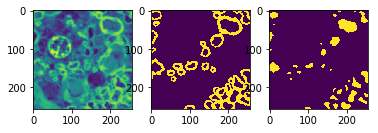

In [13]:
# Optional: Sanity check
a = next(g_train)
imgs = a[0]
masks = a[1]
print ('there are {} batches'.format(masks.shape[0]))
i=0 # choose a random value between [0-(batch_size-1)] (number of image/mask per batch)
fig, ax =plt.subplots(nrows=1,ncols=3)
ax[0].imshow(imgs[i,:,:,0])
ax[1].imshow(masks[i,:,:,1])
ax[2].imshow(masks[i,:,:,2])

### 1.3 Create generator for validation data

In [13]:
# option 1 Choose the location of the dataset manually
validation_path = 'Data/dataset_demo/Patch_for_Training/validation'
# option 1 for Mascha
# from the serve 50T take the folder  Axon/DeepSeg/UnAxSeg/Data  it contains all you need for the training
# Data/dataset_demo/Patch_for_Training/train
# Data/dataset_demo/Patch_for_Training/validation
# Data/dataset_demo/test
validation_path = 'Axon/DeepSeg/UnAxSeg/Data/dataset_demo/Patch_for_Training/validation'

In [14]:
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
validation_path =  filedialog.askdirectory(initialdir = './',\
                            title = 'choose directory /validation containing "image*.png, mask*.png"') 
print('validation_path =\'{}\''.format(validation_path))

validation_path ='/home/thibault/Documents/Thibault_Python_dev/UnAxSeg_Data/Data/dataset_demo/Patch_for_Training/validation'


In [15]:
# import the dataset as a list of tuple (np.array(image),np.array(mask) )
Data_validation = get_data(validation_path)

# Sanity check
print('list: {}'.format(type(Data_train)))
print('tuple: {}'.format(type(Data_train[0])))
print('image: {0}, Smask: {1} '.format(Data_train[0][0].shape,Data_train[0][1].shape))

list: <class 'list'>
tuple: <class 'tuple'>
image: (256, 256), Smask: (256, 256) 


In [16]:
# Create a data augmentation generator for training
g_validation = Generator_Augmented_Data(Data_validation, batch_size=10)

10 batches


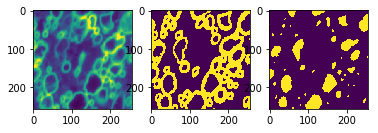

In [17]:
# Optional: Sanity check
a = next(g_validation)
imgs = a[0]
masks = a[1]
print ('{} batches'.format(masks.shape[0]))
i=0 # choose a random 0-(batch_size-1) (number of image/mask per batch)
fig, ax =plt.subplots(nrows=1,ncols=3)
ax[0].imshow(imgs[i,:,:,0])
ax[1].imshow(masks[i,:,:,1])
ax[2].imshow(masks[i,:,:,2])

### 1-4 Load data and create the generator fast

In [19]:
# location of the training data and validation data
train_path ='/home/thibault/Documents/Thibault_Python_dev/UnAxSeg_Data/Data/dataset_demo/Patch_for_Training/train'


## 2- Create a model architecture and train

In [20]:
# Create a name for the model witht the date and time of the training
currentDT = datetime.datetime.now()
date_time = currentDT.strftime("%Y-%m-%d_%H%M")
model_path = 'Models/'+ date_time +'.h5'
print ("your model will be save at : {}".format(model_path))

your model will be save at : Models/2019-08-26_1315.h5


In [21]:
from time import time
import os
from keras.callbacks import TensorBoard
log_path = "./logs/{}".format(time())
tensorboard = TensorBoard(log_dir=log_path)

In [22]:
log_path = os.path.join(os.getcwd(),log_path)
print ("log_path : \n", log_path)

log_path = os.path.join(os.getcwd(),'Logs')
tb_com_line =  'tensorboard --logdir={} &'.format(log_path)
print("To run in terminal:\n {}".format( tb_com_line))

log_path : 
 /home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/./logs/1566818150.0583653
To run in terminal:
 tensorboard --logdir=/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Logs &


## Open Tensorboard : to monitor progress
###  __In terminal command__ : Copy and execute the following

To kill the process linked to the port 6006 used by tensorflow
 - lsof -i -P -n | grep 6006
 - kill -9 $(lsof -t -i :6006 -s TCP:LISTEN)
 - tensorboard --logdir=<~/user/../logs (use the output from next cell
 - firefox http://localhost:6006 (if tensorboard is running just click on the link)
 
Alternatively run the cell "Start automatical tensorboard

In [24]:
# Start automatical tensorboard
# Run this command to open the port for tensorboard
# if the /logs folder is empty (first time you are using it or folder has been clean, run those commands
# separately in a terminal after starting the train)
with open ('run.sh', 'w') as rsh:
    rsh.write('''#! /bin/bash
    kill -9 $(lsof -t -i :6006 -s TCP:LISTEN)
    tensorboard --logdir={0} &
    '''.format(os.path.join(os.getcwd(),'Logs')))
os.chmod('run.sh', 0o755)

from subprocess import call
rc = call("./run.sh")

#os.remove('run.sh')

In [25]:
# Run the training
# Choose 
epochs = 600
steps_per_epoch = 10

train_UnAxSeg (img_size= 256, train_generator=g_train, val_generator=g_validation,
                   steps_per_epoch= steps_per_epoch, epochs= epochs,
                   model_path=model_path, tensorboard = tensorboard)

Epoch 1/600
10/10 [==============================] - 6s 598ms/step - loss: 0.7927 - acc: 0.3474 - dice_coef_ch1: 0.3597 - dice_coef_ch2: 0.2925 - val_loss: 0.7095 - val_acc: 0.4068 - val_dice_coef_ch1: 0.5523 - val_dice_coef_ch2: 0.2949
Epoch 2/600
10/10 [==============================] - 2s 182ms/step - loss: 0.6641 - acc: 0.4622 - dice_coef_ch1: 0.5368 - dice_coef_ch2: 0.3148 - val_loss: 0.6677 - val_acc: 0.5105 - val_dice_coef_ch1: 0.6190 - val_dice_coef_ch2: 0.3795
Epoch 3/600
10/10 [==============================] - 2s 180ms/step - loss: 0.5771 - acc: 0.5768 - dice_coef_ch1: 0.6306 - dice_coef_ch2: 0.3669 - val_loss: 0.6592 - val_acc: 0.5187 - val_dice_coef_ch1: 0.6442 - val_dice_coef_ch2: 0.4186
Epoch 4/600
10/10 [==============================] - 2s 180ms/step - loss: 0.5113 - acc: 0.6749 - dice_coef_ch1: 0.6537 - dice_coef_ch2: 0.4487 - val_loss: 0.6632 - val_acc: 0.6356 - val_dice_coef_ch1: 0.6634 - val_dice_coef_ch2: 0.5221
Epoch 5/600
10/10 [==============================] -

10/10 [==============================] - 2s 242ms/step - loss: 0.2009 - acc: 0.8813 - dice_coef_ch1: 0.8081 - dice_coef_ch2: 0.8591 - val_loss: 0.1949 - val_acc: 0.8855 - val_dice_coef_ch1: 0.8161 - val_dice_coef_ch2: 0.8704
Epoch 36/600
10/10 [==============================] - 2s 240ms/step - loss: 0.2047 - acc: 0.8784 - dice_coef_ch1: 0.8073 - dice_coef_ch2: 0.8572 - val_loss: 0.1985 - val_acc: 0.8878 - val_dice_coef_ch1: 0.8098 - val_dice_coef_ch2: 0.8647
Epoch 37/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1967 - acc: 0.8836 - dice_coef_ch1: 0.8111 - dice_coef_ch2: 0.8632 - val_loss: 0.1815 - val_acc: 0.8983 - val_dice_coef_ch1: 0.8192 - val_dice_coef_ch2: 0.8823
Epoch 38/600
10/10 [==============================] - 2s 243ms/step - loss: 0.2019 - acc: 0.8813 - dice_coef_ch1: 0.8084 - dice_coef_ch2: 0.8591 - val_loss: 0.1921 - val_acc: 0.8910 - val_dice_coef_ch1: 0.8139 - val_dice_coef_ch2: 0.8746
Epoch 39/600
10/10 [==============================] - 2s 242m

10/10 [==============================] - 2s 241ms/step - loss: 0.1794 - acc: 0.8938 - dice_coef_ch1: 0.8244 - dice_coef_ch2: 0.8807 - val_loss: 0.1736 - val_acc: 0.9029 - val_dice_coef_ch1: 0.8286 - val_dice_coef_ch2: 0.8827
Epoch 70/600
10/10 [==============================] - 2s 237ms/step - loss: 0.1796 - acc: 0.8929 - dice_coef_ch1: 0.8231 - dice_coef_ch2: 0.8800 - val_loss: 0.1882 - val_acc: 0.8886 - val_dice_coef_ch1: 0.8272 - val_dice_coef_ch2: 0.8780
Epoch 71/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1805 - acc: 0.8926 - dice_coef_ch1: 0.8235 - dice_coef_ch2: 0.8790 - val_loss: 0.1728 - val_acc: 0.8955 - val_dice_coef_ch1: 0.8369 - val_dice_coef_ch2: 0.8868
Epoch 72/600
10/10 [==============================] - 2s 236ms/step - loss: 0.1827 - acc: 0.8916 - dice_coef_ch1: 0.8231 - dice_coef_ch2: 0.8754 - val_loss: 0.1712 - val_acc: 0.8995 - val_dice_coef_ch1: 0.8344 - val_dice_coef_ch2: 0.8863
Epoch 73/600
10/10 [==============================] - 2s 248m

10/10 [==============================] - 2s 240ms/step - loss: 0.1772 - acc: 0.8971 - dice_coef_ch1: 0.8248 - dice_coef_ch2: 0.8812 - val_loss: 0.1764 - val_acc: 0.8972 - val_dice_coef_ch1: 0.8349 - val_dice_coef_ch2: 0.8811
Epoch 104/600
10/10 [==============================] - 2s 240ms/step - loss: 0.1784 - acc: 0.8950 - dice_coef_ch1: 0.8276 - dice_coef_ch2: 0.8787 - val_loss: 0.1758 - val_acc: 0.8943 - val_dice_coef_ch1: 0.8383 - val_dice_coef_ch2: 0.8780
Epoch 105/600
10/10 [==============================] - 2s 249ms/step - loss: 0.1730 - acc: 0.8981 - dice_coef_ch1: 0.8303 - dice_coef_ch2: 0.8835 - val_loss: 0.1694 - val_acc: 0.9031 - val_dice_coef_ch1: 0.8358 - val_dice_coef_ch2: 0.8857
Epoch 106/600
10/10 [==============================] - 2s 242ms/step - loss: 0.1693 - acc: 0.8988 - dice_coef_ch1: 0.8324 - dice_coef_ch2: 0.8891 - val_loss: 0.1690 - val_acc: 0.8986 - val_dice_coef_ch1: 0.8391 - val_dice_coef_ch2: 0.8875
Epoch 107/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 247ms/step - loss: 0.1656 - acc: 0.9020 - dice_coef_ch1: 0.8327 - dice_coef_ch2: 0.8923 - val_loss: 0.1599 - val_acc: 0.9036 - val_dice_coef_ch1: 0.8503 - val_dice_coef_ch2: 0.8956
Epoch 138/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1676 - acc: 0.9002 - dice_coef_ch1: 0.8348 - dice_coef_ch2: 0.8894 - val_loss: 0.1591 - val_acc: 0.9060 - val_dice_coef_ch1: 0.8450 - val_dice_coef_ch2: 0.8915
Epoch 139/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1723 - acc: 0.8981 - dice_coef_ch1: 0.8305 - dice_coef_ch2: 0.8842 - val_loss: 0.1732 - val_acc: 0.8966 - val_dice_coef_ch1: 0.8372 - val_dice_coef_ch2: 0.8860
Epoch 140/600
10/10 [==============================] - 2s 236ms/step - loss: 0.1685 - acc: 0.8999 - dice_coef_ch1: 0.8342 - dice_coef_ch2: 0.8881 - val_loss: 0.1648 - val_acc: 0.8989 - val_dice_coef_ch1: 0.8435 - val_dice_coef_ch2: 0.8926
Epoch 141/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 241ms/step - loss: 0.1623 - acc: 0.9044 - dice_coef_ch1: 0.8380 - dice_coef_ch2: 0.8917 - val_loss: 0.1732 - val_acc: 0.8969 - val_dice_coef_ch1: 0.8353 - val_dice_coef_ch2: 0.8874
Epoch 172/600
10/10 [==============================] - 3s 252ms/step - loss: 0.1655 - acc: 0.9024 - dice_coef_ch1: 0.8370 - dice_coef_ch2: 0.8907 - val_loss: 0.1596 - val_acc: 0.9020 - val_dice_coef_ch1: 0.8481 - val_dice_coef_ch2: 0.8914
Epoch 173/600
10/10 [==============================] - 2s 241ms/step - loss: 0.1624 - acc: 0.9028 - dice_coef_ch1: 0.8368 - dice_coef_ch2: 0.8931 - val_loss: 0.1701 - val_acc: 0.8978 - val_dice_coef_ch1: 0.8348 - val_dice_coef_ch2: 0.8923
Epoch 174/600
10/10 [==============================] - 2s 242ms/step - loss: 0.1650 - acc: 0.9017 - dice_coef_ch1: 0.8365 - dice_coef_ch2: 0.8900 - val_loss: 0.1723 - val_acc: 0.8972 - val_dice_coef_ch1: 0.8396 - val_dice_coef_ch2: 0.8858
Epoch 175/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 243ms/step - loss: 0.1601 - acc: 0.9057 - dice_coef_ch1: 0.8407 - dice_coef_ch2: 0.8939 - val_loss: 0.1648 - val_acc: 0.9029 - val_dice_coef_ch1: 0.8416 - val_dice_coef_ch2: 0.8901
Epoch 206/600
10/10 [==============================] - 2s 239ms/step - loss: 0.1616 - acc: 0.9058 - dice_coef_ch1: 0.8386 - dice_coef_ch2: 0.8906 - val_loss: 0.1679 - val_acc: 0.8995 - val_dice_coef_ch1: 0.8396 - val_dice_coef_ch2: 0.8939
Epoch 207/600
10/10 [==============================] - 2s 238ms/step - loss: 0.1594 - acc: 0.9062 - dice_coef_ch1: 0.8397 - dice_coef_ch2: 0.8961 - val_loss: 0.1635 - val_acc: 0.9025 - val_dice_coef_ch1: 0.8431 - val_dice_coef_ch2: 0.8889
Epoch 208/600
10/10 [==============================] - 2s 248ms/step - loss: 0.1608 - acc: 0.9053 - dice_coef_ch1: 0.8398 - dice_coef_ch2: 0.8932 - val_loss: 0.1633 - val_acc: 0.9035 - val_dice_coef_ch1: 0.8416 - val_dice_coef_ch2: 0.8948
Epoch 209/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 246ms/step - loss: 0.1620 - acc: 0.9049 - dice_coef_ch1: 0.8385 - dice_coef_ch2: 0.8929 - val_loss: 0.1692 - val_acc: 0.9012 - val_dice_coef_ch1: 0.8428 - val_dice_coef_ch2: 0.8821
Epoch 240/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1638 - acc: 0.9027 - dice_coef_ch1: 0.8404 - dice_coef_ch2: 0.8899 - val_loss: 0.1806 - val_acc: 0.8935 - val_dice_coef_ch1: 0.8342 - val_dice_coef_ch2: 0.8800
Epoch 241/600
10/10 [==============================] - 2s 246ms/step - loss: 0.1618 - acc: 0.9054 - dice_coef_ch1: 0.8381 - dice_coef_ch2: 0.8932 - val_loss: 0.1657 - val_acc: 0.9023 - val_dice_coef_ch1: 0.8420 - val_dice_coef_ch2: 0.8896
Epoch 242/600
10/10 [==============================] - 2s 242ms/step - loss: 0.1566 - acc: 0.9076 - dice_coef_ch1: 0.8435 - dice_coef_ch2: 0.8955 - val_loss: 0.1615 - val_acc: 0.9029 - val_dice_coef_ch1: 0.8500 - val_dice_coef_ch2: 0.8905
Epoch 243/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 242ms/step - loss: 0.1564 - acc: 0.9090 - dice_coef_ch1: 0.8428 - dice_coef_ch2: 0.8959 - val_loss: 0.1681 - val_acc: 0.9000 - val_dice_coef_ch1: 0.8459 - val_dice_coef_ch2: 0.8897
Epoch 274/600
10/10 [==============================] - 2s 247ms/step - loss: 0.1579 - acc: 0.9073 - dice_coef_ch1: 0.8422 - dice_coef_ch2: 0.8960 - val_loss: 0.1699 - val_acc: 0.8993 - val_dice_coef_ch1: 0.8462 - val_dice_coef_ch2: 0.8893
Epoch 275/600
10/10 [==============================] - 2s 245ms/step - loss: 0.1598 - acc: 0.9082 - dice_coef_ch1: 0.8398 - dice_coef_ch2: 0.8935 - val_loss: 0.1614 - val_acc: 0.9037 - val_dice_coef_ch1: 0.8454 - val_dice_coef_ch2: 0.8929
Epoch 276/600
10/10 [==============================] - 2s 248ms/step - loss: 0.1562 - acc: 0.9078 - dice_coef_ch1: 0.8426 - dice_coef_ch2: 0.8981 - val_loss: 0.1556 - val_acc: 0.9073 - val_dice_coef_ch1: 0.8501 - val_dice_coef_ch2: 0.8972
Epoch 277/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 247ms/step - loss: 0.1505 - acc: 0.9120 - dice_coef_ch1: 0.8485 - dice_coef_ch2: 0.9011 - val_loss: 0.1590 - val_acc: 0.9060 - val_dice_coef_ch1: 0.8432 - val_dice_coef_ch2: 0.8995
Epoch 308/600
10/10 [==============================] - 2s 237ms/step - loss: 0.1507 - acc: 0.9124 - dice_coef_ch1: 0.8473 - dice_coef_ch2: 0.9016 - val_loss: 0.1548 - val_acc: 0.9076 - val_dice_coef_ch1: 0.8519 - val_dice_coef_ch2: 0.9021
Epoch 309/600
10/10 [==============================] - 2s 242ms/step - loss: 0.1517 - acc: 0.9126 - dice_coef_ch1: 0.8459 - dice_coef_ch2: 0.9005 - val_loss: 0.1547 - val_acc: 0.9102 - val_dice_coef_ch1: 0.8514 - val_dice_coef_ch2: 0.8996
Epoch 310/600
10/10 [==============================] - 2s 239ms/step - loss: 0.1499 - acc: 0.9120 - dice_coef_ch1: 0.8491 - dice_coef_ch2: 0.9017 - val_loss: 0.1723 - val_acc: 0.8977 - val_dice_coef_ch1: 0.8436 - val_dice_coef_ch2: 0.8887
Epoch 311/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 250ms/step - loss: 0.1526 - acc: 0.9115 - dice_coef_ch1: 0.8470 - dice_coef_ch2: 0.8994 - val_loss: 0.1684 - val_acc: 0.8977 - val_dice_coef_ch1: 0.8406 - val_dice_coef_ch2: 0.8927
Epoch 342/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1504 - acc: 0.9118 - dice_coef_ch1: 0.8462 - dice_coef_ch2: 0.9034 - val_loss: 0.1649 - val_acc: 0.9004 - val_dice_coef_ch1: 0.8482 - val_dice_coef_ch2: 0.8889
Epoch 343/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1492 - acc: 0.9132 - dice_coef_ch1: 0.8484 - dice_coef_ch2: 0.9018 - val_loss: 0.1637 - val_acc: 0.9025 - val_dice_coef_ch1: 0.8442 - val_dice_coef_ch2: 0.8900
Epoch 344/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1539 - acc: 0.9109 - dice_coef_ch1: 0.8468 - dice_coef_ch2: 0.8983 - val_loss: 0.1702 - val_acc: 0.8996 - val_dice_coef_ch1: 0.8450 - val_dice_coef_ch2: 0.8900
Epoch 345/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 237ms/step - loss: 0.1476 - acc: 0.9141 - dice_coef_ch1: 0.8498 - dice_coef_ch2: 0.9025 - val_loss: 0.1627 - val_acc: 0.9079 - val_dice_coef_ch1: 0.8414 - val_dice_coef_ch2: 0.8919
Epoch 376/600
10/10 [==============================] - 3s 252ms/step - loss: 0.1484 - acc: 0.9134 - dice_coef_ch1: 0.8493 - dice_coef_ch2: 0.9019 - val_loss: 0.1648 - val_acc: 0.9027 - val_dice_coef_ch1: 0.8438 - val_dice_coef_ch2: 0.8922
Epoch 377/600
10/10 [==============================] - 2s 245ms/step - loss: 0.1548 - acc: 0.9090 - dice_coef_ch1: 0.8445 - dice_coef_ch2: 0.8996 - val_loss: 0.1655 - val_acc: 0.9009 - val_dice_coef_ch1: 0.8430 - val_dice_coef_ch2: 0.8896
Epoch 378/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1479 - acc: 0.9137 - dice_coef_ch1: 0.8487 - dice_coef_ch2: 0.9033 - val_loss: 0.1587 - val_acc: 0.9085 - val_dice_coef_ch1: 0.8477 - val_dice_coef_ch2: 0.8917
Epoch 379/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 243ms/step - loss: 0.1504 - acc: 0.9119 - dice_coef_ch1: 0.8486 - dice_coef_ch2: 0.9008 - val_loss: 0.1576 - val_acc: 0.9051 - val_dice_coef_ch1: 0.8501 - val_dice_coef_ch2: 0.8948
Epoch 410/600
10/10 [==============================] - 2s 246ms/step - loss: 0.1438 - acc: 0.9160 - dice_coef_ch1: 0.8516 - dice_coef_ch2: 0.9078 - val_loss: 0.1669 - val_acc: 0.9007 - val_dice_coef_ch1: 0.8496 - val_dice_coef_ch2: 0.8885
Epoch 411/600
10/10 [==============================] - 3s 311ms/step - loss: 0.1459 - acc: 0.9154 - dice_coef_ch1: 0.8517 - dice_coef_ch2: 0.9038 - val_loss: 0.1542 - val_acc: 0.9085 - val_dice_coef_ch1: 0.8544 - val_dice_coef_ch2: 0.8969
Epoch 412/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1449 - acc: 0.9157 - dice_coef_ch1: 0.8516 - dice_coef_ch2: 0.9061 - val_loss: 0.1563 - val_acc: 0.9075 - val_dice_coef_ch1: 0.8508 - val_dice_coef_ch2: 0.8963
Epoch 413/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 239ms/step - loss: 0.1438 - acc: 0.9173 - dice_coef_ch1: 0.8538 - dice_coef_ch2: 0.9052 - val_loss: 0.1611 - val_acc: 0.9097 - val_dice_coef_ch1: 0.8473 - val_dice_coef_ch2: 0.8922
Epoch 444/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1413 - acc: 0.9183 - dice_coef_ch1: 0.8553 - dice_coef_ch2: 0.9078 - val_loss: 0.1579 - val_acc: 0.9098 - val_dice_coef_ch1: 0.8487 - val_dice_coef_ch2: 0.8943
Epoch 445/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1449 - acc: 0.9156 - dice_coef_ch1: 0.8542 - dice_coef_ch2: 0.9046 - val_loss: 0.1651 - val_acc: 0.9032 - val_dice_coef_ch1: 0.8471 - val_dice_coef_ch2: 0.8941
Epoch 446/600
10/10 [==============================] - 2s 244ms/step - loss: 0.1441 - acc: 0.9173 - dice_coef_ch1: 0.8528 - dice_coef_ch2: 0.9048 - val_loss: 0.1618 - val_acc: 0.9043 - val_dice_coef_ch1: 0.8492 - val_dice_coef_ch2: 0.8918
Epoch 447/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 248ms/step - loss: 0.1455 - acc: 0.9162 - dice_coef_ch1: 0.8537 - dice_coef_ch2: 0.9037 - val_loss: 0.1580 - val_acc: 0.9044 - val_dice_coef_ch1: 0.8544 - val_dice_coef_ch2: 0.8988
Epoch 478/600
10/10 [==============================] - 2s 246ms/step - loss: 0.1431 - acc: 0.9170 - dice_coef_ch1: 0.8534 - dice_coef_ch2: 0.9071 - val_loss: 0.1675 - val_acc: 0.9044 - val_dice_coef_ch1: 0.8465 - val_dice_coef_ch2: 0.8893
Epoch 479/600
10/10 [==============================] - 2s 245ms/step - loss: 0.1436 - acc: 0.9179 - dice_coef_ch1: 0.8527 - dice_coef_ch2: 0.9059 - val_loss: 0.1701 - val_acc: 0.9031 - val_dice_coef_ch1: 0.8452 - val_dice_coef_ch2: 0.8866
Epoch 480/600
10/10 [==============================] - 2s 243ms/step - loss: 0.1417 - acc: 0.9187 - dice_coef_ch1: 0.8539 - dice_coef_ch2: 0.9079 - val_loss: 0.1641 - val_acc: 0.9026 - val_dice_coef_ch1: 0.8447 - val_dice_coef_ch2: 0.8964
Epoch 481/600
10/10 [==============================] - 2s 

 7/10 [====================>.........] - ETA: 0s - loss: 0.1414 - acc: 0.9196 - dice_coef_ch1: 0.8543 - dice_coef_ch2: 0.9070

KeyboardInterrupt: 

## 2.2 Create the train function  and Train a model

In this section, we develop pipeline to test different models and different optimizations method.
This is a good place to start experimenting with different configuration on deep learning modeling.
more advance, allow to change training parameter particularly the optimizer
This example shows how to experiment several optimizer and store the results. This is part is exploratory... a better version on that exist in the hand of Laurin.


In [5]:
# import model to train
from utility.Training_tools import UnAxSeg_2, unet_Bays_Approx

In [14]:
# quickly load the the data and create the generator
# define the paths
train_path ='/home/thibault/Documents/Thibault_Python_dev/UnAxSeg_Data/Data/dataset_demo/Patch_for_Training/train'
validation_path ='/home/thibault/Documents/Thibault_Python_dev/UnAxSeg_Data/Data/dataset_demo/Patch_for_Training/validation'

# get the data
Data_train = get_data(train_path)
Data_validation = get_data(validation_path)

# create the generator
g_train = Generator_Augmented_Data(Data_train, batch_size=10)
g_validation = Generator_Augmented_Data(Data_validation, batch_size=10)

In [15]:
# prepare or select a model
#model = UnAxSeg_2(256)
model = unet_Bays_Approx(256)

In [16]:
# choose an optimizer and parameter
#optimizer_ = optimizers.adamax(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
#optimizer_ = optimizers.Nadam(lr = 0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
optimizer_ = optimizers.adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
parameter = optimizer_.get_config()
print(parameter)

{'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


In [17]:
def train_a_model (model, optimizer_, train_generator=None, val_generator=None,
                   steps_per_epoch=10, epochs=100,
                   model_path=None, tensorboard=None):
    
    '''
    Set the model, optimizer and fit_generator for training phase and start the training
    save the model
    imput :
        model :  keras.model to train
        optimizer : keras.optimizer (example : keras.optimizers.adam())
        train_generator: should be an interator create by Generator_Augmented_Data for instance
        val_generator: same as train_generator by for validation
        steps_per_epoch:
        epochs:
        model_path: where to save the model
        tensorboard: keras.callbacks.Tensorboard(log_dir=log_path) 
    output: train model
    '''
    
    
    
    loss_fun =  losses.softmax_dice_loss_2
    #loss_fun =  losses.double_head_loss
    #loss_fun =  losses.mask_contour_mask_loss
    #loss_fun = losses.softmax_dice_loss
    #loss_fun = categorical_crossentropy
    
    # metrics
    dice_myelin=losses.dice_coef_ch1
    dice_axon =losses.dice_coef_ch2
    
    model.compile(optimizer=optimizer_, loss=loss_fun, metrics=['accuracy', dice_myelin, dice_axon])
        
    #tensorboard = TensorBoard(log_dir="logs/{}".format(time()), write_images =True)
    model.fit_generator(train_generator, steps_per_epoch= steps_per_epoch, epochs=epochs,
                        validation_data = val_generator,
                        validation_steps = steps_per_epoch //2,
                        callbacks= [tensorboard])
    
    model.save(model_path)
    
    return model

In [18]:
# Create a name for the model witht the date and time of the training
currentDT = datetime.datetime.now()
date_time = currentDT.strftime("%Y-%m-%d_%H%M")
model_path = 'Models/'+ date_time +'.h5'
print ("your model will be save at : {}".format(model_path))

your model will be save at : Models/2019-06-17_1326.h5


In [19]:
# Create the tensorboard callback function
from keras.callbacks import TensorBoard
log_path = "./logs/{}".format(date_time)
tensorboard = TensorBoard(log_dir=log_path)
print(log_path)

./logs/2019-06-17_1326


In [20]:
# write information into log_book (.txt)
log_book = 'experience_Unet.txt'
optimizer_name = optimizer_.__doc__.split('optimizer')[0]
with open("./logs/{}".format(log_book),"a") as f1:
    f1.write("{0} \t {1} : {2}\n".format(log_path,optimizer_name,parameter))

In [21]:
# Run the training
# Choose 
epochs = 600
steps_per_epoch = 10
train_a_model (model, optimizer_, train_generator=g_train, val_generator=g_validation,
                   steps_per_epoch=10, epochs=600,
                   model_path=model_path, tensorboard=tensorboard)

Epoch 1/600
10/10 [==============================] - 4s 404ms/step - loss: 0.6765 - acc: 0.3734 - dice_coef_ch1: 0.5391 - dice_coef_ch2: 0.3099 - val_loss: 0.7327 - val_acc: 0.3437 - val_dice_coef_ch1: 0.5104 - val_dice_coef_ch2: 0.3131
Epoch 2/600
10/10 [==============================] - 2s 185ms/step - loss: 0.5482 - acc: 0.5138 - dice_coef_ch1: 0.6726 - dice_coef_ch2: 0.3883 - val_loss: 0.7265 - val_acc: 0.3089 - val_dice_coef_ch1: 0.5572 - val_dice_coef_ch2: 0.3337
Epoch 3/600
10/10 [==============================] - 2s 188ms/step - loss: 0.4756 - acc: 0.6268 - dice_coef_ch1: 0.7254 - dice_coef_ch2: 0.4505 - val_loss: 0.5077 - val_acc: 0.6361 - val_dice_coef_ch1: 0.7121 - val_dice_coef_ch2: 0.4189
Epoch 4/600
10/10 [==============================] - 2s 184ms/step - loss: 0.3986 - acc: 0.7494 - dice_coef_ch1: 0.7399 - dice_coef_ch2: 0.5649 - val_loss: 0.3783 - val_acc: 0.7755 - val_dice_coef_ch1: 0.7143 - val_dice_coef_ch2: 0.7058
Epoch 5/600
10/10 [==============================] -

10/10 [==============================] - 2s 181ms/step - loss: 0.1730 - acc: 0.8894 - dice_coef_ch1: 0.8330 - dice_coef_ch2: 0.8797 - val_loss: 0.1705 - val_acc: 0.8848 - val_dice_coef_ch1: 0.8363 - val_dice_coef_ch2: 0.8779
Epoch 70/600
10/10 [==============================] - 2s 185ms/step - loss: 0.1873 - acc: 0.8798 - dice_coef_ch1: 0.8216 - dice_coef_ch2: 0.8637 - val_loss: 0.1676 - val_acc: 0.8921 - val_dice_coef_ch1: 0.8374 - val_dice_coef_ch2: 0.8837
Epoch 71/600
10/10 [==============================] - 2s 187ms/step - loss: 0.1765 - acc: 0.8846 - dice_coef_ch1: 0.8305 - dice_coef_ch2: 0.8786 - val_loss: 0.2460 - val_acc: 0.8240 - val_dice_coef_ch1: 0.7892 - val_dice_coef_ch2: 0.8067
Epoch 72/600
10/10 [==============================] - 2s 195ms/step - loss: 0.1773 - acc: 0.8876 - dice_coef_ch1: 0.8286 - dice_coef_ch2: 0.8800 - val_loss: 0.1695 - val_acc: 0.8900 - val_dice_coef_ch1: 0.8444 - val_dice_coef_ch2: 0.8736
Epoch 73/600
10/10 [==============================] - 2s 188m

10/10 [==============================] - 2s 181ms/step - loss: 0.1563 - acc: 0.8981 - dice_coef_ch1: 0.8443 - dice_coef_ch2: 0.8924 - val_loss: 0.1597 - val_acc: 0.8926 - val_dice_coef_ch1: 0.8504 - val_dice_coef_ch2: 0.8882
Epoch 138/600
10/10 [==============================] - 2s 181ms/step - loss: 0.1501 - acc: 0.9018 - dice_coef_ch1: 0.8512 - dice_coef_ch2: 0.8998 - val_loss: 0.1655 - val_acc: 0.8919 - val_dice_coef_ch1: 0.8408 - val_dice_coef_ch2: 0.8841
Epoch 139/600
10/10 [==============================] - 2s 183ms/step - loss: 0.1595 - acc: 0.8983 - dice_coef_ch1: 0.8447 - dice_coef_ch2: 0.8852 - val_loss: 0.1619 - val_acc: 0.8925 - val_dice_coef_ch1: 0.8480 - val_dice_coef_ch2: 0.8863
Epoch 140/600
10/10 [==============================] - 2s 183ms/step - loss: 0.1511 - acc: 0.9020 - dice_coef_ch1: 0.8500 - dice_coef_ch2: 0.8970 - val_loss: 0.1525 - val_acc: 0.8981 - val_dice_coef_ch1: 0.8534 - val_dice_coef_ch2: 0.8888
Epoch 141/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 181ms/step - loss: 0.1522 - acc: 0.9012 - dice_coef_ch1: 0.8503 - dice_coef_ch2: 0.8965 - val_loss: 0.1478 - val_acc: 0.8937 - val_dice_coef_ch1: 0.8573 - val_dice_coef_ch2: 0.8971
Epoch 206/600
10/10 [==============================] - 2s 182ms/step - loss: 0.1470 - acc: 0.9037 - dice_coef_ch1: 0.8565 - dice_coef_ch2: 0.8979 - val_loss: 0.1520 - val_acc: 0.8997 - val_dice_coef_ch1: 0.8546 - val_dice_coef_ch2: 0.8953
Epoch 207/600
10/10 [==============================] - 2s 181ms/step - loss: 0.1529 - acc: 0.9008 - dice_coef_ch1: 0.8497 - dice_coef_ch2: 0.8950 - val_loss: 0.1475 - val_acc: 0.9000 - val_dice_coef_ch1: 0.8558 - val_dice_coef_ch2: 0.8985
Epoch 208/600
10/10 [==============================] - 2s 181ms/step - loss: 0.1381 - acc: 0.9112 - dice_coef_ch1: 0.8619 - dice_coef_ch2: 0.9066 - val_loss: 0.1610 - val_acc: 0.8935 - val_dice_coef_ch1: 0.8462 - val_dice_coef_ch2: 0.8878
Epoch 209/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 187ms/step - loss: 0.1505 - acc: 0.9020 - dice_coef_ch1: 0.8573 - dice_coef_ch2: 0.8906 - val_loss: 0.1645 - val_acc: 0.8841 - val_dice_coef_ch1: 0.8444 - val_dice_coef_ch2: 0.8869
Epoch 274/600
10/10 [==============================] - 2s 185ms/step - loss: 0.1391 - acc: 0.9104 - dice_coef_ch1: 0.8603 - dice_coef_ch2: 0.9047 - val_loss: 0.1657 - val_acc: 0.8885 - val_dice_coef_ch1: 0.8460 - val_dice_coef_ch2: 0.8776
Epoch 275/600
10/10 [==============================] - 2s 186ms/step - loss: 0.1410 - acc: 0.9086 - dice_coef_ch1: 0.8611 - dice_coef_ch2: 0.9056 - val_loss: 0.1504 - val_acc: 0.8992 - val_dice_coef_ch1: 0.8517 - val_dice_coef_ch2: 0.8945
Epoch 276/600
10/10 [==============================] - 2s 186ms/step - loss: 0.1406 - acc: 0.9084 - dice_coef_ch1: 0.8587 - dice_coef_ch2: 0.9034 - val_loss: 0.1623 - val_acc: 0.8897 - val_dice_coef_ch1: 0.8465 - val_dice_coef_ch2: 0.8865
Epoch 277/600
10/10 [==============================] - 2s 

10/10 [==============================] - 2s 187ms/step - loss: nan - acc: 0.5169 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5249 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 347/600
10/10 [==============================] - 2s 184ms/step - loss: nan - acc: 0.5203 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5205 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 348/600
10/10 [==============================] - 2s 184ms/step - loss: nan - acc: 0.5126 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5102 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 349/600
10/10 [==============================] - 2s 186ms/step - loss: nan - acc: 0.5042 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5200 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 350/600
10/10 [==============================] - 2s 184ms/step - loss: nan - acc: 0.5127 - dice_coef_ch1: nan - dice_coef_ch

10/10 [==============================] - 2s 184ms/step - loss: nan - acc: 0.5226 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5174 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 421/600
10/10 [==============================] - 2s 186ms/step - loss: nan - acc: 0.5271 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5086 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 422/600
10/10 [==============================] - 2s 185ms/step - loss: nan - acc: 0.5047 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5121 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 423/600
10/10 [==============================] - 2s 184ms/step - loss: nan - acc: 0.5085 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5261 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 424/600
10/10 [==============================] - 2s 186ms/step - loss: nan - acc: 0.5046 - dice_coef_ch1: nan - dice_coef_ch

10/10 [==============================] - 2s 194ms/step - loss: nan - acc: 0.5130 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5449 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 495/600
10/10 [==============================] - 2s 196ms/step - loss: nan - acc: 0.5223 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5258 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 496/600
10/10 [==============================] - 2s 186ms/step - loss: nan - acc: 0.5308 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5212 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 497/600
10/10 [==============================] - 2s 186ms/step - loss: nan - acc: 0.5336 - dice_coef_ch1: nan - dice_coef_ch2: nan - val_loss: nan - val_acc: 0.5336 - val_dice_coef_ch1: nan - val_dice_coef_ch2: nan
Epoch 498/600
10/10 [==============================] - 2s 187ms/step - loss: nan - acc: 0.5025 - dice_coef_ch1: nan - dice_coef_ch

KeyboardInterrupt: 

## 3-  Test


In [ ]:
# option 1 Choose the test image of the dataset manually
test_path = 'Data/dataset_demo/test/sample5/image.png'
# option 1 for Mascha
# from the serve 50T take the folder  Axon/DeepSeg/UnAxSeg/Data  it contains all you need for the training
# Data/dataset_demo/Patch_for_Training/train
# Data/dataset_demo/Patch_for_Training/validation
# Data/dataset_demo/test
test_path = 'Axon/DeepSeg/UnAxSeg/Data/dataset_demo/test/sample5/image.png'

In [28]:
# option 2 Choose the image to test using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
test_path =  filedialog.askopenfilename(initialdir = './',\
                            title = 'choose the image to test "image.png') 

In [29]:
img_test, _ = Import_image(filename = test_path)

In [33]:
# If you want to test an other model that the one you just trained
# change it here
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
model_path =  filedialog.askopenfilename(initialdir = './Models',\
                            title = 'Choose the model to test "*.h5"') 

# the models are located in UnAxSeg/unet_4_user/Models and have a .h5 extension (i.e. 2019-06-12_0952.h5)

In [38]:
# import the model
model_path='Models/model_in_use.h5'
model_to_test=Import_model(model_path = model_path)
print('we are using the model: {}'.format(model_path))

we are using the model: Models/model_in_use.h5


In [39]:
from keras.models import load_model
model = load_model(model_path, custom_objects={'softmax_dice_loss_2': losses.softmax_dice_loss_2,
                                               'dice_coef_ch1':losses.dice_coef_ch1,
                                              'dice_coef_ch2':losses.dice_coef_ch2})

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 256, 256, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 256, 256, 1)  0           lambda_9[0][0]                   
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 256, 256, 16) 160         lambda_10[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [40]:
prediction = Unet_by_patches(img_test, model_to_test, patch_size=256, overlap=64, RGB = True)

100%|██████████| 25/25 [00:01<00:00,  6.89it/s]


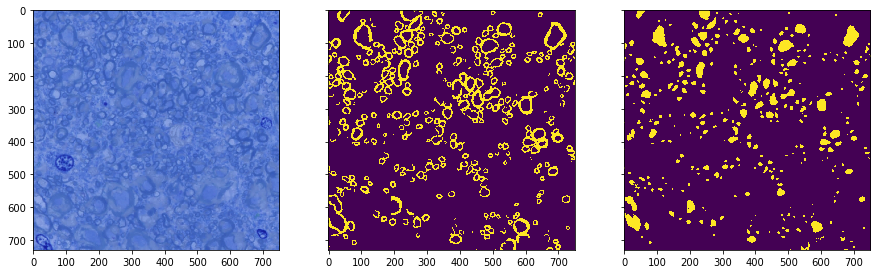

In [37]:
# Create the mask using argmax apply in 3th dimension
mask = np.argmax(prediction, axis=-1)

pred_axon = mask== 2
pred_myelin = mask == 1

# Plot image and mask
myelin_mask = np.array(mask==1, dtype= np.uint8)
axon_mask = np.array(mask==2, dtype= np.uint8)

fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(15,10))
ax[0].imshow(np.array(img_test))
ax[1].imshow(myelin_mask)
ax[2].imshow(axon_mask)

## 4- Performance check

__Todo__

In [3]:
model_1=UnAxSeg(256)
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 1)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [4]:
model_1=UnAxSeg_2(256)
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 1)  0           lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 32) 320         lambda_4[0][0]                   
__________________________________________________________________________________________________
batch_norm

4608